In [1]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from collections import defaultdict, Counter
import seaborn as sns

In [2]:
def analyze_dataset(data_root):
    """Analyze the pig behavior dataset from the Edinburgh structure"""
    data_root = Path(data_root)
    annotated_dir = data_root / "annotated"
    
    if not annotated_dir.exists():
        raise FileNotFoundError(f"Annotated directory not found: {annotated_dir}")

    # Statistics containers
    video_stats = []
    behavior_stats = []
    bbox_stats = []
    
    print(f"Analyzing dataset in: {annotated_dir}")

    # Process each annotation file in all date folders
    for annotation_file in annotated_dir.rglob("*/output.json"):
        try:
            with open(annotation_file, 'r') as f:
                data = json.load(f)
            
            # Video file is in the same directory as output.json
            video_path = annotation_file.parent / "color.mp4"
            
            if not video_path.exists():
                print(f"Warning: Video file not found: {video_path}")
                continue
            
            # Extract date and video ID from path
            date_folder = annotation_file.parent.parent.name
            video_id = annotation_file.parent.name
            
            # Get video properties
            cap = cv2.VideoCapture(str(video_path))
            if not cap.isOpened():
                print(f"Warning: Could not open video file: {video_path}")
                continue
                
            fps = cap.get(cv2.CAP_PROP_FPS)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            duration = total_frames / fps if fps > 0 else 0
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            cap.release()
            
            video_stats.append({
                'date': date_folder,
                'video_id': video_id,
                'fps': fps,
                'total_frames': total_frames,
                'duration': duration,
                'width': width,
                'height': height,
                'num_objects': len(data.get('objects', []))
            })
            
            # Process each object (pig)
            for obj_idx, obj in enumerate(data.get('objects', [])):
                frames_data = obj.get('frames', [])
                
                for frame_data in frames_data:
                    frame_num = frame_data.get('frameNumber', 0)
                    behavior = frame_data.get('behaviour', 'unknown')
                    bbox = frame_data.get('bbox', {})
                    
                    behavior_stats.append({
                        'date': date_folder,
                        'video_id': video_id,
                        'object_id': obj_idx,
                        'behavior': behavior,
                        'frame_number': frame_num,
                        'timestamp': frame_num / fps if fps > 0 else 0
                    })
                    
                    if bbox:
                        bbox_stats.append({
                            'date': date_folder,
                            'video_id': video_id,
                            'object_id': obj_idx,
                            'behavior': behavior,
                            'x': bbox.get('x', 0),
                            'y': bbox.get('y', 0),
                            'width': bbox.get('width', 0),
                            'height': bbox.get('height', 0),
                            'area': bbox.get('width', 0) * bbox.get('height', 0)
                        })
        
        except Exception as e:
            print(f"Error processing {annotation_file}: {str(e)}")
            continue
    
    # Convert to DataFrames
    video_df = pd.DataFrame(video_stats) if video_stats else pd.DataFrame()
    behavior_df = pd.DataFrame(behavior_stats) if behavior_stats else pd.DataFrame()
    bbox_df = pd.DataFrame(bbox_stats) if bbox_stats else pd.DataFrame()
    
    return video_df, behavior_df, bbox_df


In [3]:
def print_dataset_summary(video_df, behavior_df, bbox_df):
    """Print detailed dataset summary"""
    print("\n" + "="*50)
    print("DATASET SUMMARY")
    print("="*50)
    
    print(f"Total Videos: {len(video_df)}")
    print(f"Total Annotations: {len(behavior_df)}")
    print(f"Date Range: {video_df['date'].min()} to {video_df['date'].max()}")
    print(f"Average Video Duration: {video_df['duration'].mean():.2f} seconds")
    print(f"Total Dataset Duration: {video_df['duration'].sum():.2f} seconds ({video_df['duration'].sum()/60:.1f} minutes)")
    
    print(f"\nBehavior Classes:")
    behavior_counts = behavior_df['behavior'].value_counts()
    for behavior, count in behavior_counts.items():
        percentage = (count / len(behavior_df)) * 100
        print(f"  {behavior}: {count} annotations ({percentage:.1f}%)")
    
    print(f"\nVideo Properties:")
    print(f"  Resolution: {video_df['width'].mode().iloc[0] if not video_df.empty else 'N/A'} x {video_df['height'].mode().iloc[0] if not video_df.empty else 'N/A'}")
    print(f"  FPS: {video_df['fps'].mode().iloc[0] if not video_df.empty else 'N/A'}")
    print(f"  Average Objects per Video: {video_df['num_objects'].mean():.1f}")
    
    print(f"\nBounding Box Statistics:")
    print(f"  Average Width: {bbox_df['width'].mean():.1f} pixels")
    print(f"  Average Height: {bbox_df['height'].mean():.1f} pixels")
    print(f"  Average Area: {bbox_df['area'].mean():.1f} pixels²")
    
    # Class balance analysis
    print(f"\nClass Balance Analysis:")
    min_class = behavior_counts.min()
    max_class = behavior_counts.max()
    imbalance_ratio = max_class / min_class
    print(f"  Most common behavior: {behavior_counts.idxmax()} ({behavior_counts.max()} samples)")
    print(f"  Least common behavior: {behavior_counts.idxmin()} ({behavior_counts.min()} samples)")
    print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")
    
    if imbalance_ratio > 3:
        print(f"  ⚠️  Warning: High class imbalance detected!")
        print(f"     Consider data augmentation or class weighting")

In [4]:





def visualize_dataset_statistics(video_df, behavior_df, bbox_df):
    """Create visualizations for dataset statistics"""
    
    plt.figure(figsize=(20, 15))
    
    # 1. Video duration distribution
    plt.subplot(3, 4, 1)
    plt.hist(video_df['duration'], bins=20, alpha=0.7, color='skyblue')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Number of Videos')
    plt.title('Video Duration Distribution')
    
    # 2. FPS distribution
    plt.subplot(3, 4, 2)
    plt.hist(video_df['fps'], bins=20, alpha=0.7, color='lightgreen')
    plt.xlabel('FPS')
    plt.ylabel('Number of Videos')
    plt.title('FPS Distribution')
    
    # 3. Number of objects per video
    plt.subplot(3, 4, 3)
    plt.hist(video_df['num_objects'], bins=range(1, max(video_df['num_objects'])+2), 
             alpha=0.7, color='orange')
    plt.xlabel('Number of Objects (Pigs)')
    plt.ylabel('Number of Videos')
    plt.title('Objects per Video')
    
    # 4. Behavior distribution
    plt.subplot(3, 4, 4)
    behavior_counts = behavior_df['behavior'].value_counts()
    plt.pie(behavior_counts.values, labels=behavior_counts.index, autopct='%1.1f%%')
    plt.title('Behavior Distribution')
    
    # 5. Behavior counts by date
    plt.subplot(3, 4, 5)
    behavior_by_date = behavior_df.groupby(['date', 'behavior']).size().unstack(fill_value=0)
    behavior_by_date.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.xlabel('Date')
    plt.ylabel('Number of Annotations')
    plt.title('Behavior Counts by Date')
    plt.xticks(rotation=45)
    
    # 6. Bounding box area distribution
    plt.subplot(3, 4, 6)
    plt.hist(bbox_df['area'], bins=30, alpha=0.7, color='purple')
    plt.xlabel('Bounding Box Area (pixels)')
    plt.ylabel('Number of Annotations')
    plt.title('Bounding Box Area Distribution')
    
    # 7. Bounding box width vs height
    plt.subplot(3, 4, 7)
    plt.scatter(bbox_df['width'], bbox_df['height'], alpha=0.5, s=10)
    plt.xlabel('Width (pixels)')
    plt.ylabel('Height (pixels)')
    plt.title('Bounding Box Dimensions')
    
    # 8. Behavior duration (consecutive frames)
    plt.subplot(3, 4, 8)
    behavior_durations = []
    for (date, video_id, obj_id), group in behavior_df.groupby(['date', 'video_id', 'object_id']):
        group = group.sort_values('frame_number')
        current_behavior = None
        duration = 0
        
        for _, row in group.iterrows():
            if row['behavior'] == current_behavior:
                duration += 1
            else:
                if current_behavior is not None:
                    behavior_durations.append({'behavior': current_behavior, 'duration': duration})
                current_behavior = row['behavior']
                duration = 1
        
        if current_behavior is not None:
            behavior_durations.append({'behavior': current_behavior, 'duration': duration})
    
    duration_df = pd.DataFrame(behavior_durations)
    if not duration_df.empty:
        sns.boxplot(data=duration_df, x='behavior', y='duration', ax=plt.gca())
        plt.xlabel('Behavior')
        plt.ylabel('Duration (frames)')
        plt.title('Behavior Duration Distribution')
        plt.xticks(rotation=45)
    
    # 9. Temporal distribution of behaviors
    plt.subplot(3, 4, 9)
    behavior_df['hour'] = behavior_df['timestamp'] // 3600  # Convert to hours
    behavior_by_time = behavior_df.groupby(['hour', 'behavior']).size().unstack(fill_value=0)
    behavior_by_time.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.xlabel('Hour')
    plt.ylabel('Number of Annotations')
    plt.title('Behavior Distribution Over Time')
    
    # 10. Object position heatmap
    plt.subplot(3, 4, 10)
    if not bbox_df.empty:
        # Calculate center points
        bbox_df['center_x'] = bbox_df['x'] + bbox_df['width'] / 2
        bbox_df['center_y'] = bbox_df['y'] + bbox_df['height'] / 2
        
        plt.hexbin(bbox_df['center_x'], bbox_df['center_y'], gridsize=20, cmap='Blues')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.title('Pig Position Heatmap')
        plt.colorbar(label='Frequency')
    
    # 11. Behavior transition matrix
    plt.subplot(3, 4, 11)
    transitions = []
    for (date, video_id, obj_id), group in behavior_df.groupby(['date', 'video_id', 'object_id']):
        group = group.sort_values('frame_number')
        behaviors = group['behavior'].tolist()
        for i in range(len(behaviors) - 1):
            transitions.append({'from': behaviors[i], 'to': behaviors[i+1]})
    
    if transitions:
        transition_df = pd.DataFrame(transitions)
        transition_matrix = pd.crosstab(transition_df['from'], transition_df['to'])
        sns.heatmap(transition_matrix, annot=True, fmt='d', cmap='Blues', ax=plt.gca())
        plt.title('Behavior Transition Matrix')
    
    # 12. Dataset size by date
    plt.subplot(3, 4, 12)
    date_counts = video_df['date'].value_counts().sort_index()
    plt.bar(date_counts.index, date_counts.values, alpha=0.7, color='coral')
    plt.xlabel('Date')
    plt.ylabel('Number of Videos')
    plt.title('Dataset Size by Date')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('dataset_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()



Starting dataset analysis...
Analyzing dataset in: C:\Users\2955352g\Desktop\pig_data_edinburgh\annotated

DATASET SUMMARY
Total Videos: 12
Total Annotations: 12646
Date Range: 2019_11_05 to 2019_12_10
Average Video Duration: 60.00 seconds
Total Dataset Duration: 720.00 seconds (12.0 minutes)

Behavior Classes:
  investigating: 4203 annotations (33.2%)
  walk: 2736 annotations (21.6%)
  standing: 1812 annotations (14.3%)
  eat: 980 annotations (7.7%)
  fight: 807 annotations (6.4%)
  lying: 601 annotations (4.8%)
  sleep: 530 annotations (4.2%)
  nose-to-nose: 358 annotations (2.8%)
  drink: 211 annotations (1.7%)
  sitting: 144 annotations (1.1%)
  run: 106 annotations (0.8%)
  playwithtoy: 85 annotations (0.7%)
  nose-poke-elsewhere: 62 annotations (0.5%)
  jumpontopof: 6 annotations (0.0%)
  other: 4 annotations (0.0%)
  chase: 1 annotations (0.0%)

Video Properties:
  Resolution: 1280 x 720
  FPS: 30.0
  Average Objects per Video: 8.0

Bounding Box Statistics:
  Average Width: 203.

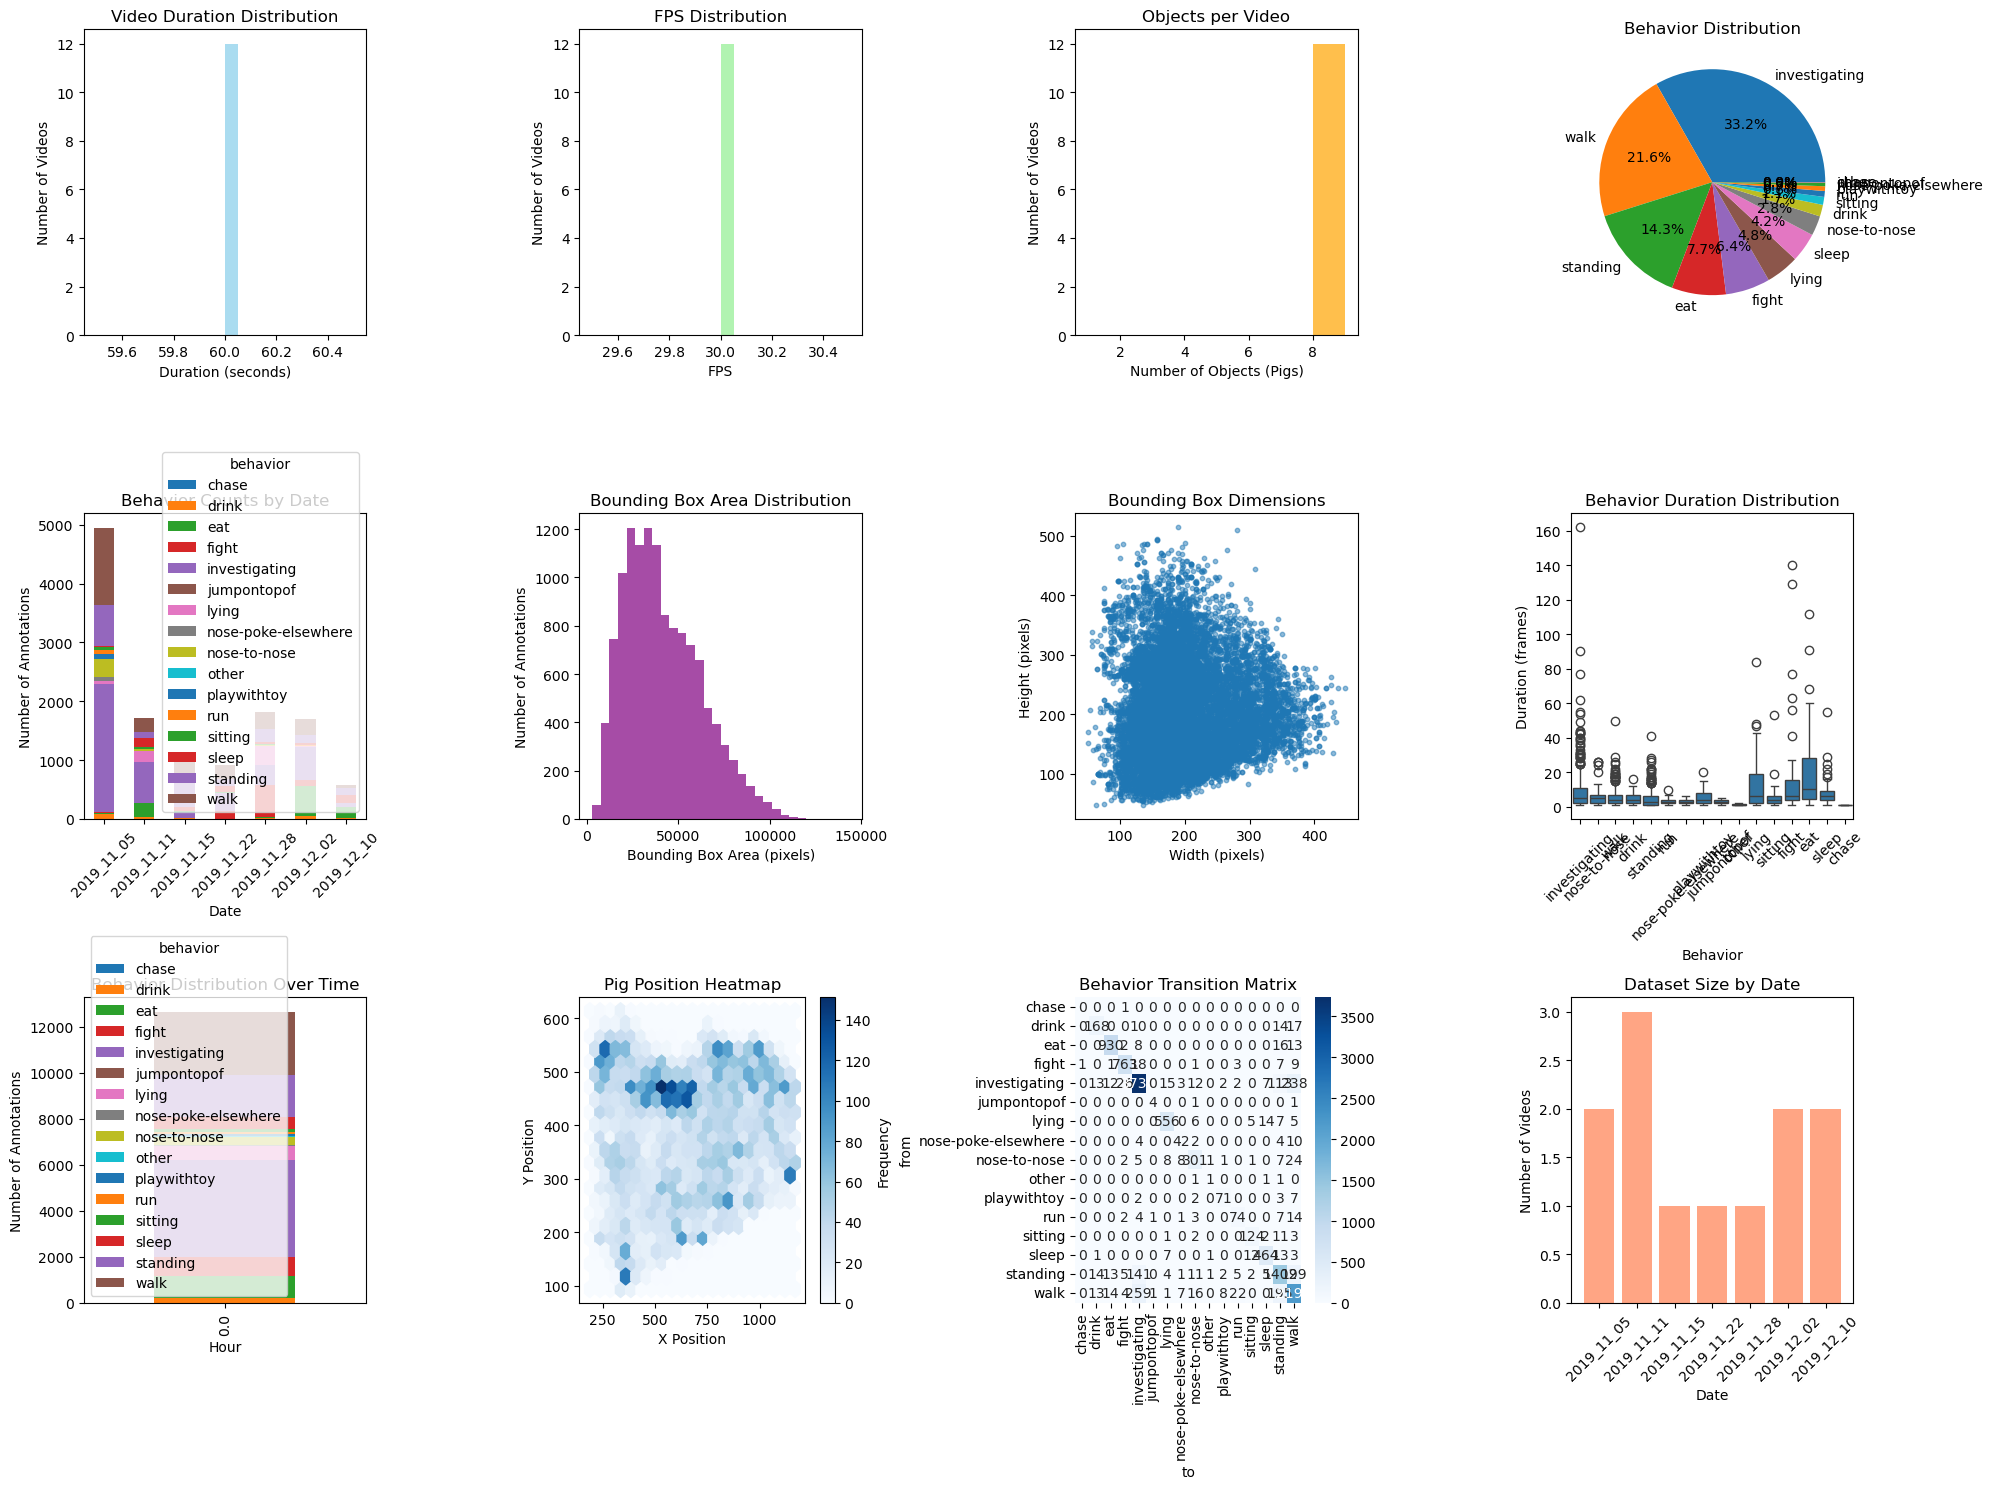

Analysis results saved to: C:\Users\2955352g\Desktop\Thesis\Codes\output_annotated_data


In [5]:
def main():
    # Set this to your main data directory
    DATA_ROOT = r"C:\Users\2955352g\Desktop\pig_data_edinburgh"
    
    print("Starting dataset analysis...")
    video_df, behavior_df, bbox_df = analyze_dataset(DATA_ROOT)
    
    if video_df.empty:
        print("No valid data found. Please check your dataset path and structure.")
        return
    
    print_dataset_summary(video_df, behavior_df, bbox_df)
    visualize_dataset_statistics(video_df, behavior_df, bbox_df)
    
    # Save analysis results
    output_dir = Path(r"C:\Users\2955352g\Desktop\Thesis\Codes\output_annotated_data")
    output_dir.mkdir(exist_ok=True)
    
    video_df.to_csv(output_dir / 'video_analysis.csv', index=False)
    behavior_df.to_csv(output_dir / 'behavior_analysis.csv', index=False)
    bbox_df.to_csv(output_dir / 'bbox_analysis.csv', index=False)
    print(f"Analysis results saved to: {output_dir}")

if __name__ == "__main__":
    main()